In [1]:
import sys
import numpy as np
import pickle
from mne_bids import BIDSPath, read_raw_bids
from bids import BIDSLayout
from util.io.coherence import *
from util.io.iter_BIDSPaths import *
from mne_connectivity import spectral_connectivity_time, check_indices
from scipy.signal import coherence

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mne.decoding import SlidingEstimator, cross_val_multiscore, Scaler, Vectorizer

In [2]:
SUB = '31'
RUN = '1'
TASK = 'pitch'
FPATH = '/project2/hcn1/pitch_tracking/data/bids/derivatives/preprocessing/sub-31/sub-31_task-pitch_run-1_res-hi_desc-clean_epo.fif.gz'

BIDS_ROOT = '../data/bids'
FIGS_ROOT = '../figs'

DERIV_ROOT = '../data/bids/derivatives'
METHOD = 'coh'
FS = 5000
RAW_TMIN = -0.2
RAW_TMAX = 0.5
TMIN = 0
TMAX = 0.25
N_CHANS = 62
CONDS = ['50', '100', '150', '200', '250']
FREQS = [50, 100, 150, 200, 250]

In [3]:
# Load epoched data
epochs = mne.read_epochs(FPATH, preload = True)
events = epochs.events
n_epochs = len(events)

Reading /project2/hcn1/pitch_tracking/data/bids/derivatives/preprocessing/sub-31/sub-31_task-pitch_run-1_res-hi_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -200.00 ...     250.00 ms
        0 CTF compensation matrices available
Reading /project2/hcn1/pitch_tracking/data/bids/derivatives/preprocessing/sub-31/sub-31_task-pitch_run-1_res-hi_desc-clean_epo.fif-1.gz ...
    Found the data of interest:
        t =    -200.00 ...     250.00 ms
        0 CTF compensation matrices available
Not setting metadata
4801 matching events found
No baseline correction applied
0 projection items activated


In [4]:
# Use a different sub for generating stim channels if sub has bad Aux channel
STIM_SUB, STIM_RUN = get_stim_sub(SUB, RUN)

In [5]:
# Create epochs from raw data to create simulated stim channels
raw_epochs = get_raw_epochs(BIDS_ROOT, STIM_SUB, TASK, STIM_RUN)
stim_epochs_array = create_stim_epochs_array(raw_epochs, n_epochs, CONDS)
simulated_epochs = create_stim_epochs_object(stim_epochs_array, events, CONDS, FS, RAW_TMIN)

Used Annotations descriptions: ['100', '150', '200', '250', '50']


/project2/hcn1/pitch_tracking/scripts/util/io/coherence.py:42: RuntimeWarning: The unit for channel(s) Aux1 has changed from NA to V.
  raw = read_raw_bids(bids_path, verbose = False)
/project2/hcn1/pitch_tracking/scripts/util/io/coherence.py:42: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['leog', 'reog', 'Aux1']
  raw = read_raw_bids(bids_path, verbose = False)
/project2/hcn1/pitch_tracking/scripts/util/io/coherence.py:42: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Aux1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path, verbose = False)


Not setting metadata
6000 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1180 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 1234 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 1216 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 1219 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 1151 events and 3501 original time points ...
0 bad epochs dropped
Not setting metadata
4801 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [6]:
# Crop data so both epoch objects have same windowing
# epochs is (4801, 62, 1251) which is (epochs, channels, time points)
# simulated epochs is (5, 1251) which is (freqs, time points)

simulated_epochs = simulated_epochs.crop(tmin = TMIN, tmax = TMAX)
epochs = epochs.crop(tmin = TMIN)

In [7]:
# Keep only one version of stim signals
stim_array = simulated_epochs.get_data()[0, :, :]

In [8]:
# Create target array
labels = pd.Series(events[:, 2])
y = labels.replace({10001 : 0, 10002 : 1, 10003 : 2, 10004 : 3, 10005 : 4})
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

### Keep coherence values at all stim freqs for each stim

In [9]:
# What shape does it need to be for decoding?? Keep this in mind!
# Shape of Zxx for stft is n_epochs, n_freqs*n_chans, n_windows
# Shape of Zxx in general is a trials, features, time array
# Shape of Zxx in this case is n_epochs, n_chans, n_stim, n_freqs

# Compute coherence
epoch_array = epochs.get_data()
n_epochs = np.shape(epoch_array)[0]
n_chans = np.shape(epoch_array)[1]
n_stim = 5
n_freqs = 5

X = np.zeros((n_epochs, n_chans, n_stim, n_freqs))

for epoch in range(n_epochs):
    epoch_X = []
    for channel in range(n_chans):
        current_epoch = epoch_array[epoch, channel, :]
        for stim in range(n_stim):
            current_freq = stim_array[stim, :]
            
            # compute coherence
            f, Cxy = coherence(current_epoch, current_freq, FS)
            
            # get coherences for condition frequencies only
            Cxy = extract_coherence_for_condition_frequencies(FREQS, f, Cxy) 
            
            # add to array
            X[epoch, channel, stim, :] = Cxy

#             break
#         break
#     break

#### Decode

In [19]:
X = X.reshape((4801, 62, 5*5))

In [20]:
n_stimuli = 5
metric = 'accuracy'

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver = 'liblinear')
)

print("Creating sliding estimators")
time_decod = SlidingEstimator(clf)

print("Fit estimators")
scores = cross_val_multiscore(
    time_decod,
    X, # a trials x features x time array
    y, # an (n_trials,) array of integer condition labels
    cv = 5, # use stratified 5-fold cross-validation
    n_jobs = -1, # use all available CPU cores
)
scores = np.mean(scores, axis = 0) # average across cv splits

Creating sliding estimators
Fit estimators


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
  0%|          | Fitting SlidingEstimator : 0/25 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/25 [00:00<?,       ?it/s]






  0%|          | Fitting SlidingEstimator : 0/25 [00:00<?,       ?it/s]
  0%|          | Fitting SlidingEstimator : 0/25 [00:00<?,       ?it/s]
  4%|▍         | Fitting SlidingEstimator : 1/25 [00:00<00:08,    2.70it/s]






  4%|▍         | Fitting SlidingEstimator : 1/25 [00:00<00:08,    2.70it/s]

  4%|▍         | Fitting SlidingEstimator : 1/25 [00:00<00:09,    2.48it/s]
  8%|▊         | Fitting SlidingEstimator : 2/25 [00:00<00:06,    3.50it/s]



  8%|▊         | Fitting SlidingEstimator : 2/25 [00:00<00:07,    2.98it/s]


  8%|▊         | Fitting SlidingEstimator : 2/25 [00:00<00:07,    2.98it/s]

  8%|▊         | Fitting SlidingEstimator : 2/25 [00:00<00:08,    2.71it/s]
 12%|█▏        | Fitting SlidingEstimator : 3/25 [00:00<00:06,    3.20it/s]






 

100%|██████████| Fitting SlidingEstimator : 25/25 [00:06<00:00,    3.68it/s]


100%|██████████| Fitting SlidingEstimator : 25/25 [00:06<00:00,    3.62it/s]
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.0s finished


#### Plot

Text(0.5, 1.0, 'Sensor space decoding')

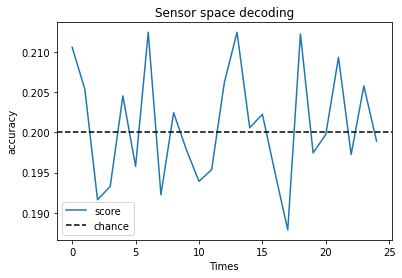

In [21]:
fig, ax = plt.subplots()
ax.plot(range(len(scores)), scores, label = 'score')
ax.axhline(1/n_stimuli, color = 'k', linestyle = '--', label = 'chance')
ax.set_xlabel('Times')
ax.set_ylabel(metric)  # Area Under the Curve
ax.legend()
ax.set_title('Sensor space decoding')

### Keep only coherence values at the frequency of each stim

In [27]:
# What shape does it need to be for decoding?? Keep this in mind!
# Shape of Zxx for stft is n_epochs, n_freqs*n_chans, n_windows
# Shape of Zxx in general is a trials, features, time array
# Shape of Zxx in this case is n_epochs, n_chans, n_stim, n_freqs

# Compute coherence
epoch_array = epochs.get_data()
n_epochs = np.shape(epoch_array)[0]
n_chans = np.shape(epoch_array)[1]
n_stim = 5

X = np.zeros((n_epochs, n_chans, n_stim))

for epoch in range(n_epochs):
    epoch_X = []
    for channel in range(n_chans):
        current_epoch = epoch_array[epoch, channel, :]
        for stim in range(n_stim):
            current_freq = stim_array[stim, :]
            
            # compute coherence
            f, Cxy = coherence(current_epoch, current_freq, FS)
            
            # get coherences for condition frequencies only
            Cxy = extract_coherence_at_condition_frequencies(FREQS[stim], f, Cxy) 
            
            # add to array
            X[epoch, channel, stim] = Cxy

#             break
#         break
#     break

#### Decode

In [87]:
n_stimuli = 5
metric = 'accuracy'

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver = 'liblinear')
)

print("Creating sliding estimators")
time_decod = SlidingEstimator(clf)

print("Fit estimators")
scores = cross_val_multiscore(
    time_decod,
    X, # a trials x features x time array
    y, # an (n_trials,) array of integer condition labels
    cv = 5, # use stratified 5-fold cross-validation
    n_jobs = -1, # use all available CPU cores
)
scores = np.mean(scores, axis = 0) # average across cv splits

Creating sliding estimators
Fit estimators


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.






  0%|          | Fitting SlidingEstimator : 0/5 [00:00<?,       ?it/s]



  0%|          | Fitting SlidingEstimator : 0/5 [00:00<?,       ?it/s]



 20%|██        | Fitting SlidingEstimator : 1/5 [00:00<00:01,    3.30it/s]


 20%|██        | Fitting SlidingEstimator : 1/5 [00:00<00:01,    2.98it/s]


 20%|██        | Fitting SlidingEstimator : 1/5 [00:00<00:01,    2.97it/s]



 40%|████      | Fitting SlidingEstimator : 2/5 [00:00<00:00,    3.31it/s]


 40%|████      | Fitting SlidingEstimator : 2/5 [00:00<00:00,    3.13it/s]


 40%|████      | Fitting SlidingEstimator : 2/5 [00:00<00:01,    2.98it/s]



 60%|██████    | Fitting SlidingEstimator : 3/5 [00:00<00:00,    3.44it/s]
 60%|██████    | Fitting SlidingEstimator : 3/5 [00:00<00:00,    3.43it/s]




 60%|██████    | Fitting SlidingEstimator : 3/5 [00:00<00:00,    3.09it/s]



 80%|████████  | Fitting SlidingEstimator : 4/5 [00:01<00:00,    3.75it/s

#### Plot

Text(0.5, 1.0, 'Sensor space decoding')

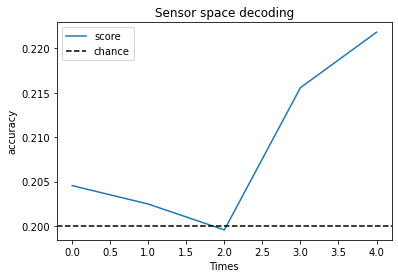

In [88]:
fig, ax = plt.subplots()
ax.plot(range(len(scores)), scores, label = 'score')
ax.axhline(1/n_stimuli, color = 'k', linestyle = '--', label = 'chance')
ax.set_xlabel('Times')
ax.set_ylabel(metric)  # Area Under the Curve
ax.legend()
ax.set_title('Sensor space decoding')

### Take only coherence against actual stim

In [72]:
# What shape does it need to be for decoding?? Keep this in mind!
# Shape of Zxx for stft is n_epochs, n_freqs*n_chans, n_windows
# Shape of Zxx in general is a trials, features, time array
# Shape of Zxx in this case is n_epochs, n_chans, n_stim, n_freqs

# Compute coherence
epoch_array = epochs.get_data()
n_epochs = np.shape(epoch_array)[0]
n_chans = np.shape(epoch_array)[1]
n_freq = 5

X = np.zeros((n_epochs, n_chans, n_freq))

for epoch in range(n_epochs):
    epoch_X = []
    for channel in range(n_chans):
        
        # get signal for current epoch
        current_epoch = epoch_array[epoch, channel, :]
        
        # get signal for stim for current epoch
        stim_index = y[epoch]
        current_stim = stim_array[stim_index, :]
            
        # compute coherence
        f, Cxy = coherence(current_epoch, current_stim, FS)

        # get coherences for condition frequencies only
        Cxy = extract_coherence_for_condition_frequencies(FREQS, f, Cxy) 

        # add to array
        X[epoch, channel, ] = Cxy

In [ ]:
save_fp = f'../data/bids/derivatives/coherence/sub-{SUB}_task-{TASK}_run-{RUN}_coh-by-epoch.pkl'
X.to_pickle(save_fp)

#### Decode

In [54]:
scores = np.mean(scores, axis = 0)

In [96]:
n_stimuli = 5
metric = 'accuracy'

# clf = make_pipeline(
#     StandardScaler(),
#     LogisticRegression(solver = 'liblinear')
# )

clf = make_pipeline(Vectorizer(),
                    LogisticRegression(solver='liblinear'))

# clf = make_pipeline(Scaler(epochs.info),
#                     Vectorizer(),
#                     LogisticRegression(solver='liblinear'))

print("Creating sliding estimators")
time_decod = SlidingEstimator(clf)

print("Fit estimators")
scores = cross_val_multiscore(
    time_decod,
    X, # a trials x features x freq
    y, # an (n_trials,) array of integer condition labels
    cv = 5, # use stratified 5-fold cross-validation
    n_jobs = -1, # use all available CPU cores
)
scores = np.mean(scores, axis = 0) # average across cv splits

Creating sliding estimators
Fit estimators


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
  0%|          | Fitting SlidingEstimator : 0/5 [00:00<?,       ?it/s]



  0%|          | Fitting SlidingEstimator : 0/5 [00:00<?,       ?it/s]
 20%|██        | Fitting SlidingEstimator : 1/5 [00:00<00:00,    5.95it/s]


  0%|          | Fitting SlidingEstimator : 0/5 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/5 [00:00<?,       ?it/s]
 20%|██        | Fitting SlidingEstimator : 1/5 [00:00<00:00,    5.94it/s]



 40%|████      | Fitting SlidingEstimator : 2/5 [00:00<00:00,    5.95it/s]

 20%|██        | Fitting SlidingEstimator : 1/5 [00:00<00:00,    5.93it/s]


 20%|██        | Fitting SlidingEstimator : 1/5 [00:00<00:00,    4.95it/s]
 60%|██████    | Fitting SlidingEstimator : 3/5 [00:00<00:00,    6.40it/s]



 40%|████      | Fitting SlidingEstimator : 2/5 [00:00<00:00,    4.95it/s]
 60%|██████    | Fitting SlidingEstimator : 3/5 [00:00<00:00,    5.93it/s]

 40%|████      | Fittin

#### Plot

Text(0.5, 1.0, 'Sensor space decoding')

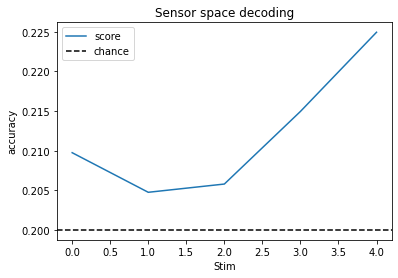

In [97]:
fig, ax = plt.subplots()
ax.plot(range(len(scores)), scores, label = 'score')
ax.axhline(1/n_stimuli, color = 'k', linestyle = '--', label = 'chance')
ax.set_xlabel('Stim')
ax.set_ylabel(metric)  # Area Under the Curve
ax.legend()
ax.set_title('Sensor space decoding')

In [101]:
sub31coh = pd.read_pickle('../data/bids/derivatives/coherence/subj-31_task-pitch_run-1_coh-by-condition.pkl')

In [104]:
sub31coh[['50', '100', '150', '200', '250']]

,50,100,150,200,250
0,0.020111,0.015085,0.019800,0.010302,0.027572
1,0.190030,0.039468,0.019181,0.012786,0.030420
2,0.194530,0.016744,0.020079,0.021302,0.022076
3,0.031064,0.017140,0.032818,0.014417,0.021075
4,0.150465,0.034541,0.019261,0.026198,0.025064
...,...,...,...,...,...
305,0.032434,0.026935,0.018614,0.031585,0.015325
306,0.035209,0.033350,0.013293,0.019620,0.066791
307,0.044825,0.032291,0.049411,0.025386,0.086167
308,0.032230,0.025084,0.017127,0.050485,0.192383


In [105]:
sub31coh

,index,sub,cond,chan,50,100,150,200,250
0,0,31,50,1,0.020111,0.015085,0.019800,0.010302,0.027572
1,1,31,50,2,0.190030,0.039468,0.019181,0.012786,0.030420
2,2,31,50,3,0.194530,0.016744,0.020079,0.021302,0.022076
3,3,31,50,4,0.031064,0.017140,0.032818,0.014417,0.021075
4,4,31,50,5,0.150465,0.034541,0.019261,0.026198,0.025064
...,...,...,...,...,...,...,...,...,...
305,57,31,250,58,0.032434,0.026935,0.018614,0.031585,0.015325
306,58,31,250,59,0.035209,0.033350,0.013293,0.019620,0.066791
307,59,31,250,60,0.044825,0.032291,0.049411,0.025386,0.086167
308,60,31,250,61,0.032230,0.025084,0.017127,0.050485,0.192383
